In [1]:
import gzip
import math
import os
import re
import sys
from enum import Enum
from io import StringIO
from time import time

import matplotlib.pyplot as pyplot
import numpy
import pandas as pd
import requests
import tensorflow
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential




In [3]:
PRNG_SEED = 42

numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

In [7]:
# create 'data' cache directory
parent_dir = "C:/Users/16609/AI-Threat-Detection-System/AI-Threat-Detection-System"
directory ="data"

path = os.path.join(parent_dir,directory)
if not os.path.exists(path):
    os.makedirs(path)

The dataset files are available here: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [8]:
DATASET_COLUMNS_FILE = os.path.join(path,"kddcup1999_columns.txt")

if not os.path.exists(DATASET_COLUMNS_FILE):
    with requests.get("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names") as request:
        with open(DATASET_COLUMNS_FILE, 'wb') as file:
            file.write(request.content)

In [10]:
ColumnType = Enum('ColumnType', 'SYMBOLIC CONTINUOUS')
column_types = {}

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = ColumnType[match.group("data_type").upper()]

In [11]:
DATASET_URL = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
DATASET_FILE = os.path.join("data", "kddcup1999.csv")

# download dataset if not already cached
if not os.path.exists(DATASET_FILE):
    with requests.get(DATASET_URL) as response:
        if response.status_code != 200:
            raise RuntimeError(f"failed to download dataset: {DATASET_URL}")
        # decompress content
        with open(DATASET_FILE, 'wb') as file:
            file.write(gzip.decompress(response.content))

In [12]:
dataframe = pd.read_csv(
    # file to import from
    DATASET_FILE,
    # important to specify the CSV file contains no headers
    # otherwise, the first record is interpreted as a header
    header=None,
)
dataframe.columns = [*column_types.keys(), "outcome"]

pd.set_option('display.max_rows', 10)
dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


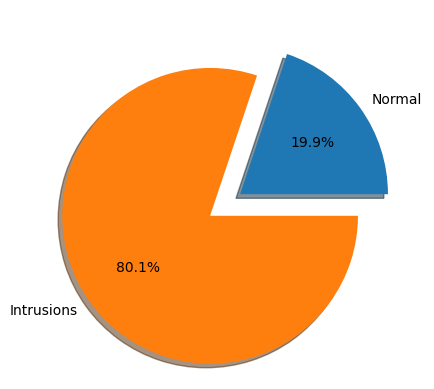

In [13]:
type_frequencies = dataframe['outcome'].value_counts()
normal_frequency = type_frequencies['normal.']
intrusion_frequency = sum([count for outcome_type, count in type_frequencies.items() if outcome_type != 'normal.'])

figure = pyplot.figure()
pyplot.pie(
    [normal_frequency, intrusion_frequency],
    labels=["Normal", "Intrusions"],
    explode=[0, .25],
    autopct='%1.1f%%',
    shadow=True,
)
pyplot.show()

In [14]:
intrusion_frequencies=type_frequencies.drop(labels=["normal."])

pd.set_option('display.max_rows', None)
display(
    pd.DataFrame(
        intrusion_frequencies.values,
        columns=['frequency'],
        index=[intrusion_name[:-1] for intrusion_name in intrusion_frequencies.index]
    ).sort_values(by="frequency", ascending=False)
)
pd.set_option('display.max_rows', 10)

,frequency
smurf,2807886
neptune,1072017
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979
pod,264


In [15]:
unique_dataframe = dataframe.drop_duplicates()

print(f"Dropped {len(dataframe) - len(unique_dataframe):,}/{len(dataframe):,} (-{100*(len(dataframe) - len(unique_dataframe))/len(dataframe):.2f}%) duplicate records")

Dropped 3,823,439/4,898,431 (-78.05%) duplicate records


In [16]:
encoded_dataframe = pd.get_dummies(
    unique_dataframe,
    # all categorical columns
    columns=[column_name for column_name, column_type in column_types.items() if column_type == ColumnType.SYMBOLIC],
    # drop original column
    drop_first=True,
)

pd.set_option('display.max_rows', 10)
encoded_dataframe

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_1,logged_in_1,is_host_login_1,is_guest_login_1
0,0,215,45076,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
1,0,162,4528,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
2,0,236,1228,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
3,0,233,2032,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
4,0,239,486,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,212,2288,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
4898427,0,219,236,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
4898428,0,218,3610,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
4898429,0,219,1234,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,True,False,False


In [17]:
TRAINING_PROPORTION = .25
TESTING_PROPORTION = .70
VALIDATION_PROPORTION = .05

assert TRAINING_PROPORTION + TESTING_PROPORTION + VALIDATION_PROPORTION <= 1.0

partitions = {'train': pd.DataFrame()}

remaining_dataframe = pd.DataFrame()
grouped_outcomes = encoded_dataframe.groupby('outcome')
maximum_per_class = math.ceil((TRAINING_PROPORTION * len(grouped_outcomes.groups['normal.'])) / (len(grouped_outcomes.groups.keys()) - 1))

In [18]:
grouped_outcomes.get_group('back.')

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_1,logged_in_1,is_host_login_1,is_guest_login_1
395614,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
395615,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
395616,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
395617,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
395618,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764838,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
4764839,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
4764840,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
4764841,0,54540,8314,0,0,2,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False


In [19]:
for key in grouped_outcomes.groups.keys():
    group = grouped_outcomes.get_group(key)

    training, remaining = train_test_split(
        group,
        shuffle=True,
        train_size=min(math.ceil(TRAINING_PROPORTION * len(group.index)), maximum_per_class) if key != "normal." else TRAINING_PROPORTION,
    )
    if key != "normal.":
        training = training.sample(n=maximum_per_class, replace=True, random_state=PRNG_SEED)
    partitions['train'] = pd.concat([partitions['train'], training])
    remaining_dataframe = pd.concat([remaining_dataframe, remaining])
partitions['test'], partitions['validate'] = train_test_split(
    remaining_dataframe,
    shuffle=True,
    train_size=TESTING_PROPORTION / (1 - TRAINING_PROPORTION),
    test_size=VALIDATION_PROPORTION / (1 - TRAINING_PROPORTION),
)

In [20]:
pd.set_option("mode.chained_assignment", None)

for column_name, column_type in column_types.items():
    if column_type == ColumnType.CONTINUOUS:
        mean = partitions['train'][column_name].mean()
        std = partitions['train'][column_name].std()
        if std == 0:
            std = 1

        for partition_name, dataframe in partitions.items():
            dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std

C:\Users\16609\AppData\Local\Temp\ipykernel_9324\642053529.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.11656596 -0.11656596 -0.11656596 ... -0.1123934  -0.1123934
 -0.11656596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std
C:\Users\16609\AppData\Local\Temp\ipykernel_9324\642053529.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.11573145 -0.11656596 -0.11656596 ... -0.11656596 -0.11656596
 -0.11656596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std
C:\Users\16609\AppData\Local\Temp\ipykernel_9324\642053529.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futu

In [21]:
tf_input = {
    partition_name: dataframe.drop("outcome", axis="columns").reset_index(drop=True)
    for partition_name, dataframe in partitions.items()
}

In [24]:
tf_output = {
    partition_name: pd.DataFrame(
        # one-hot-encode normal vs intrusions for binary classification
        [
            [1, 0] if outcome == 'normal.' else [0, 1]
            for outcome in dataframe[['outcome']].to_numpy()
        ],
        # binary classification of connection
        columns=['normal', 'intrusion'],
    )
    for partition_name, dataframe in partitions.items()
}

In [25]:
# build model
model = Sequential(
    [
        Dense(128, input_dim=tf_input['train'].shape[1]),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(tf_output['train'].shape[1], activation='softmax')
    ],
    name="kdd_cup_1999_classification"
)
# set optimizer settings
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# print model summary
model.summary()

c:\Users\16609\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "kdd_cup_1999_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,258 (102.57 KB)

 Trainable params: 26,258 (102.57 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
start_time = time()

# store standard out stream
original_stdout = sys.stdout
# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:
    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=.001, patience=100, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.keras", save_best_only=True, verbose=0)
        ],
        epochs=1000,
        verbose=2,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>➤ Training Details</b></summary>\
        {"<br>".join(captured_stdout.getvalue().splitlines())}\
    </details>\
'))


Model trained in 5646.307736 seconds


In [27]:
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.keras")
# compute predicted ratings for test dataset
predicted = numpy.argmax(model.predict(tf_input['test']), axis=1)

print(f"Predicted {len(predicted):,} classifications in {time() - start_time:.6f} seconds")

25012/25012 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
Predicted 800,368 classifications in 80.559539 seconds


,normal,intrusion
normal,568315,740
intrusion,139,231174


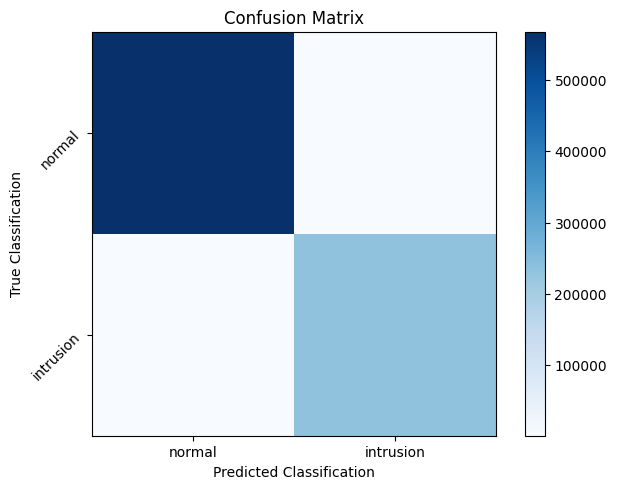

In [28]:
# compute confusion matrix
true_output = numpy.argmax(tf_output['test'].to_numpy(), axis=1)
cm = confusion_matrix(true_output, predicted)

# display confusion matrix values
display(pd.DataFrame(cm, columns=tf_output['test'].columns, index=tf_output['test'].columns))
# display a confusion matrix visualization
pyplot.figure()
pyplot.imshow(cm, interpolation='nearest', cmap=pyplot.cm.Blues)
pyplot.title("Confusion Matrix")
pyplot.colorbar()
tick_marks = numpy.arange(len(tf_output['test'].columns))
pyplot.xticks(tick_marks, tf_output['test'].columns)
pyplot.yticks(tick_marks, tf_output['test'].columns, rotation=45)
pyplot.tight_layout()
pyplot.ylabel("True Classification")
pyplot.xlabel("Predicted Classification")
pyplot.show()